<a href="https://colab.research.google.com/github/aadhil96/Malaria_Cell_Classification_with_VGG16/blob/main/Malaria_Cell_Classification_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Cell Classification with VGG16**

In [5]:
! pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"aadhilimam","key":"5229a84b438c67382805cf0403396ae9"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 670M/675M [00:05<00:00, 103MB/s]
100% 675M/675M [00:05<00:00, 121MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('cell-images-for-detecting-malaria.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import fnmatch
import tensorflow as tf
from time import sleep
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as k
import matplotlib.image as mpimg

from tensorflow.keras import layers 
from tensorflow.keras import Model

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
plt.rcParams['figure.figsize'] = (12,7)

In [10]:
print(os.listdir("/content/files/cell_images"))

['Parasitized', 'cell_images', 'Uninfected']


In [11]:
# Setting paths and showing the number of images
infected = os.listdir("/content/files/cell_images/Parasitized")
infected_path = "/content/files/cell_images/Parasitized"
print("Length of infected data = ", len(infected), 'images')
uninfected = os.listdir("/content/files/cell_images/Uninfected")
uninfected_path = "/content/files/cell_images/Uninfected"
print("Length of uninfected data = ", len(uninfected), 'images')

Length of infected data =  13780 images
Length of uninfected data =  13780 images


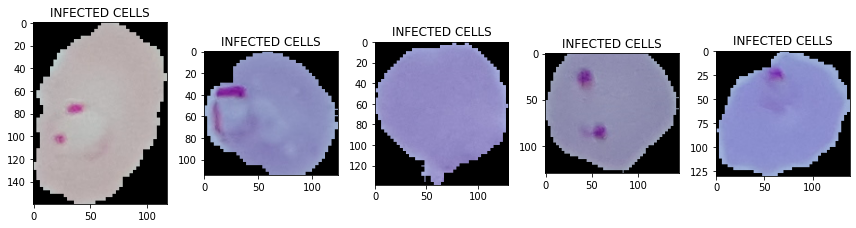

In [12]:
# Infected cells

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(infected_path + '/' + infected[i]))
    plt.title('INFECTED CELLS')
    plt.tight_layout()
plt.show()

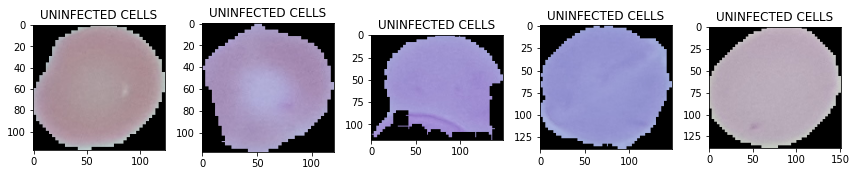

In [13]:
# Uninfected cells

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.imread(uninfected_path + '/' + uninfected[i]))
    plt.title('UNINFECTED CELLS')
    plt.tight_layout()
plt.show()

In [14]:
# Defining Image Data Gen

img_shape = (130, 130, 3)
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

In [15]:
train = image_gen.flow_from_directory('/content/files/cell_images/cell_images',
                                     target_size = img_shape[:2],
                                     color_mode = 'rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'training',
                                     shuffle = True)

validation = image_gen.flow_from_directory('/content/files/cell_images/cell_images',
                                     target_size = img_shape[:2],
                                     color_mode ='rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'validation',
                                     shuffle = False)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [16]:
train.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (128, 128, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
#Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy',metrics = ['acc'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [21]:
vgghist = model.fit(train, validation_data = validation, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 49s 411ms/step - loss: 0.9477 - acc: 0.7008 - val_loss: 0.2777 - val_acc: 0.8895
Epoch 2/10
100/100 [==============================] - 39s 397ms/step - loss: 0.2990 - acc: 0.8725 - val_loss: 0.2543 - val_acc: 0.8971
Epoch 3/10
100/100 [==============================] - 39s 396ms/step - loss: 0.2937 - acc: 0.8778 - val_loss: 0.2804 - val_acc: 0.8808
Epoch 4/10
100/100 [==============================] - 39s 396ms/step - loss: 0.2662 - acc: 0.8936 - val_loss: 0.2441 - val_acc: 0.8967
Epoch 5/10
100/100 [==============================] - 39s 397ms/step - loss: 0.2585 - acc: 0.8993 - val_loss: 0.2222 - val_acc: 0.9109
Epoch 6/10
100/100 [==============================] - 40s 397ms/step - loss: 0.2439 - acc: 0.9105 - val_loss: 0.2472 - val_acc: 0.8944
Epoch 7/10
100/100 [==============================] - 39s 396ms/step - loss: 0.2252 - acc: 0.9115 - val_loss: 0.2245 - val_acc: 0.9065
Epoch 8/10
100/100 [==============================] - 3

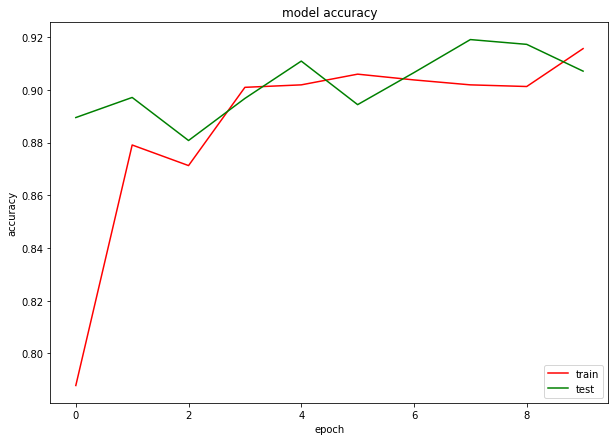

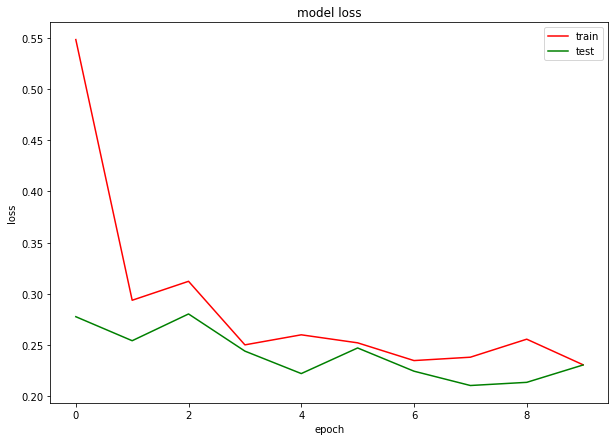

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(vgghist.history['acc'], color='red')
ax.plot(vgghist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(vgghist.history['loss'], color='red')
ax.plot(vgghist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()